# **Experiment 3 | EC69210**
****
**Code Authors:** Irsh Vijay (21EC39055) and Aditya Raj (21EC39001)

In [1]:
!gdown "1imKGFVYLWmTbHMtFu1G70ezUb1ygKNc4"
!unzip "dataset.zip" -d "data/"

Downloading...
From: https://drive.google.com/uc?id=1imKGFVYLWmTbHMtFu1G70ezUb1ygKNc4
To: /Users/irsh/Documents/workdir/ec69210/exp3/dataset.zip
100%|██████████████████████████████████████| 4.40M/4.40M [00:00<00:00, 9.16MB/s]
Archive:  dataset.zip
  inflating: data/z-dimension.csv    
  inflating: data/c7.png             
  inflating: data/c8.png             
  inflating: data/c9.png             
  inflating: data/c6.png             
  inflating: data/c3.png             
  inflating: data/c1.png             
  inflating: data/c5.png             
  inflating: data/c2.png             
  inflating: data/c4.png             


In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
z_values = pd.read_csv('data/z-dimension.csv')
z_values

,Image Name,Z-Cordinates (in mm)
0,c1,400
1,c2,500
2,c3,600
3,c4,700
4,c5,800
5,c6,900
6,c7,1000
7,c8,1100
8,c9,1200


In [3]:
class Imagette:
  def __init__(self, file_path, z):
    self.img, self.image = self._read_image(file_path)
    self.z = z

    corner1 = self._find_first_corner(self.img[:, :])
    corner2 = self._find_first_corner(self.img[::-1, :])
    corner3 = self._find_first_corner(self.img[::-1, ::-1])
    corner4 = self._find_first_corner(self.img[:, ::-1])

    self.uvs = (
        corner1,
        (1024-corner2[0], corner2[1]),
        (1024-corner3[0], 1024-corner3[1]),
        (corner4[0], 1024-corner4[1]),
    )

    self.XYZs = (
        (0, 0, z),
        (7*25, 0, z),
        (7*25, 10*25, z),
        (0, 10*25, z)
    )

    self.A = self._make_A_matrix(self.uvs, self.XYZs)

  @staticmethod
  def _read_image(file_path):
    image = Image.open(file_path).convert('L')
    img = np.asarray(image).astype(float)
    return img, image

  @staticmethod
  def _find_first_corner(img):
    prev_val = img[0, 0]

    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        if abs(img[i, j] - prev_val) > 5:
          return (i, j)
        prev_val = img[i, j]

  @staticmethod
  def _make_A_matrix(uvs, XYZs):
    A = np.zeros((8, 12))

    for i in range(0, 8, 2):
      A[i, 0:4] = [*XYZs[i//2], 1]
      A[i+1, 4:8] = [*XYZs[i//2], 1]
      A[i, 8:12] = [(-uvs[i//2][0]) * coord for coord in [*XYZs[i//2], 1]]
      A[i+1, 8:12] = [(-uvs[i//2][1]) * coord for coord in [*XYZs[i//2], 1]]

    return A

  def plot(self):
    plt.imshow(self.img, cmap='gray')

  def plot_points(self, *points):
    points = np.array(points).astype(int)
    plt.scatter(points[:, 1], points[:, 0])

In [4]:
images = [
    Imagette(f"data/{row._1}.png", row._2) for row in z_values.itertuples()
    ]

In [5]:
combined_A = np.vstack([im.A for im in images])

In [6]:
combined_A.shape

(72, 12)

In [7]:
def SVD(A):
  ATA = np.dot(A.T, A)
  AAT = np.dot(A, A.T)

  eigenvalues_ATA, eigenvectors_ATA = np.linalg.eig(ATA)
  eigenvalues_AAT, eigenvectors_AAT = np.linalg.eig(AAT)

  idx = eigenvalues_ATA.argsort()[::-1]
  eigenvalues_ATA = eigenvalues_ATA[idx]
  eigenvectors_ATA = eigenvectors_ATA[:, idx]

  idx = eigenvalues_AAT.argsort()[::-1]
  eigenvalues_AAT = eigenvalues_AAT[idx]
  eigenvectors_AAT = eigenvectors_AAT[:, idx]

  s = np.sqrt(eigenvalues_ATA)

  U = eigenvectors_AAT
  V = eigenvectors_ATA

  return U, s, V

In [8]:
P = SVD(combined_A)[2][:, -1].reshape((3, 4))

def projection(X, Y, Z):
  point = np.array([X, Y, Z, 1])[..., np.newaxis]
  p = P @ point
  return tuple((p / p[-1])[:, 0][:2])

P

array([[ 6.46152166e-03,  3.59453630e-07,  2.32767966e-03,
        -5.66249125e-01],
       [ 1.25094145e-07,  6.46069647e-03,  2.32723503e-03,
        -8.24176924e-01],
       [ 1.99908390e-10,  6.79771608e-10,  4.54622411e-06,
        -1.68910327e-06]])

In [9]:
print(f'Point corresponding to world coordinate: {images[0].XYZs[0]} is really {images[0].uvs[0]}')

print(f"Estimated: {projection(*images[0].XYZs[0])}")

Point corresponding to world coordinate: (0, 0, 400) is really (201, 59)
Estimated: (np.float64(200.80505869995582), np.float64(58.73902291350864))


In [10]:
def check_projection(image, projection):
  z = image.z
  real_world_grid = [(i*25, j*25, z) for i in range(8) for j in range(11)]

  image.plot()
  image.plot_points(*[projection(*pt) for pt in real_world_grid])
  image.plot_points(projection(3.5*25, 5*25, z))

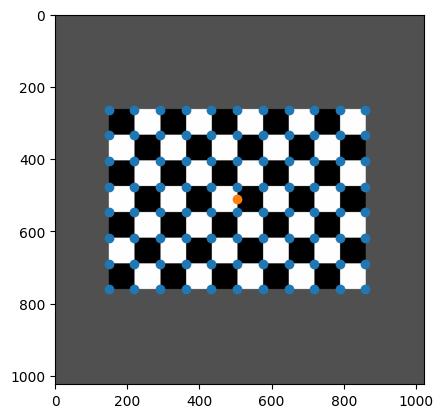

In [11]:
check_projection(images[1], projection)

Using QR Decomposition for `K` calculation
| [Reference](https://www.youtube.com/watch?v=6TIVIw4B5VA&list=PLxKgD50sMRvBHxvNPnGQ1kEHlO5y7mSnh)

In [12]:
from scipy.linalg import rq

def compute_intrinsic_matrix(P):
    # Extract the left 3x3 submatrix of P
    M = P[:3, :3]
    
    # Perform RQ decomposition
    K, R = rq(M)
    
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Normalize K so that K[2, 2] = 1
    K = K / K[2, 2]
    
    return K, R

In [13]:
K, R = compute_intrinsic_matrix(P)

In [14]:
K

array([[1.42127160e+03, 7.50731937e-03, 5.12065338e+02],
       [0.00000000e+00, 1.42103605e+03, 5.12117519e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])